# The situation

Type C thermocouples are not NIST calibrated to below 273.15 K. For my research specific scenario, I need to cool my sample (Molybdenum) to cryogenic temperatures and also anneal to very high ~2000 K. There is no thermocouple with these properties. 




### The solution

We know that Type K thermocouples are accurate down to cryogenic temperatures. So what I've done here is to read the Type K temperature and record the corresponding Type C mV to create a calibration table. Both thermocouples were spot welded to a large mass very close to one another to ensure the temperature readings will be accurate.

Then I will use a polynomial fit to get the low T calibration for the Type C thermocouple.

In [36]:
# import a few packages
%matplotlib notebook
from thermocouples_reference import thermocouples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


typeC=thermocouples['C']

In [2]:
# make sure you are in the same dir as the file
# read in the file and drop Na cols
df = pd.read_excel('Type C Table 4-2-18.xlsx')
df.dropna(axis=1, inplace=True)
df.head()

        T  TypeKmV    CJC  TypeCmV
0  295.68     0.90  25.27    0.021
1  292.79     0.78  25.27   -0.017
2  292.04     0.74  25.26   -0.028
3  291.22     0.72  25.26   -0.037
4  290.56     0.69  25.26   -0.045


In [3]:
# NIST has values calibrated for T > 273.15 K, lets find the Tref based on these points
# I am using Kelvin for all T. The CJC is quoted in deg C.
tempdf = df.query('T>273.15')
tempdf.head()

,T,TypeKmV,CJC,TypeCmV
0,295.68,0.90,25.27,0.021
1,292.79,0.78,25.27,-0.017
2,292.04,0.74,25.26,-0.028
3,291.22,0.72,25.26,-0.037
4,290.56,0.69,25.26,-0.045


In [4]:
# Let's find the T_ref by using this function to take the TypeC mV and the T to find the Tref
def find_Tref(mV, T):
    x = np.arange(290, 301, 0.01)
    x = x[::-1] # lets reverse x
    i = 1
    while typeC.inverse_KmV(mV, Tref=x[i]) - T >= 0:
        i += 1
#     print(x[i])
    return x[i]

In [5]:
# This isn't the fastest way to do things, but since its just a short amount of rows, lets iterate over the mV and T
# to find Tref
Treflist=[]
for idx in tempdf.index:
    # print(idx)
    Treflist.append(find_Tref(mV=tempdf['TypeCmV'][idx], T=tempdf['T'][idx]))


[294.1599999999962, 294.00999999999635, 294.0499999999963, 293.88999999999646, 293.80999999999653, 293.9299999999964, 293.9599999999964, 294.1499999999962, 294.0799999999963, 294.20999999999617, 294.1799999999962, 294.2999999999961, 294.31999999999607, 294.23999999999614, 294.369999999996, 294.2799999999961, 294.379999999996, 294.369999999996, 294.419999999996, 294.419999999996, 294.409999999996, 294.419999999996, 294.53999999999587, 294.46999999999593, 294.57999999999583, 294.4799999999959, 294.57999999999583, 294.54999999999586, 294.64999999999577, 294.7099999999957, 294.7199999999957, 294.5999999999958, 294.6999999999957, 294.7099999999957, 294.67999999999574, 294.7199999999957, 294.7299999999957, 294.8099999999956, 294.8599999999956, 294.77999999999565, 294.8299999999956, 294.7399999999957, 295.77999999999474, 294.97999999999547, 295.0599999999954, 294.98999999999546, 294.98999999999546, 294.9199999999955, 294.88999999999555, 294.9499999999955, 295.0799999999954, 294.90999999999553

In [6]:
print( ['%0.2f'% x for x in Treflist])

['294.16', '294.01', '294.05', '293.89', '293.81', '293.93', '293.96', '294.15', '294.08', '294.21', '294.18', '294.30', '294.32', '294.24', '294.37', '294.28', '294.38', '294.37', '294.42', '294.42', '294.41', '294.42', '294.54', '294.47', '294.58', '294.48', '294.58', '294.55', '294.65', '294.71', '294.72', '294.60', '294.70', '294.71', '294.68', '294.72', '294.73', '294.81', '294.86', '294.78', '294.83', '294.74', '295.78', '294.98', '295.06', '294.99', '294.99', '294.92', '294.89', '294.95', '295.08', '294.91', '295.03', '295.05', '295.17', '295.11', '295.10', '295.12', '295.16', '295.20', '295.13', '295.19', '295.19', '295.25', '295.26', '295.24']


In [9]:
# now average the Trefs:
avg_Tref = np.mean(Treflist)
print(avg_Tref)
# I will use this Tref for further calcs
Tref_emf = typeC.emf_mVK(avg_Tref)
print(Tref_emf)
# The Tref_emf value is very close to the value in the table at 273.15 K, so we'll use this value to correct the new values
# The value taken at 273.15 K was during the cooling process and is likely to be less accurate than the room temperature value
# across these multiple observations

294.6749999999957
0.2937438416187858


In [15]:
# The emf correction for 273.15 K is then: calibrated_emf = raw_emf + Tref_emf

# Let's add this to the df we initially imported...

df['TypeC_calib_mV'] = df['TypeCmV'] + Tref_emf

df.head()
# Compared to the NIST table, we appear to be off at most a little less than 1 deg K


,T,TypeKmV,CJC,TypeCmV,TypeC_calib_mV
0,295.68,0.90,25.27,0.021,0.314744
1,292.79,0.78,25.27,-0.017,0.276744
2,292.04,0.74,25.26,-0.028,0.265744
3,291.22,0.72,25.26,-0.037,0.256744
4,290.56,0.69,25.26,-0.045,0.248744


In [14]:
# Had we used the CJC temperature as a proxy for room temp, we would've been even more off.
# compare the TypeCmV using Tref = CJC vs using Tref = 294.67:
print(typeC.emf_mVK(291.22, Tref =(25.26+273.15)))
print(typeC.emf_mVK(291.22, Tref =avg_Tref))

-0.09996884322359076
-0.0478884150234353


<IPython.core.display.Javascript object>


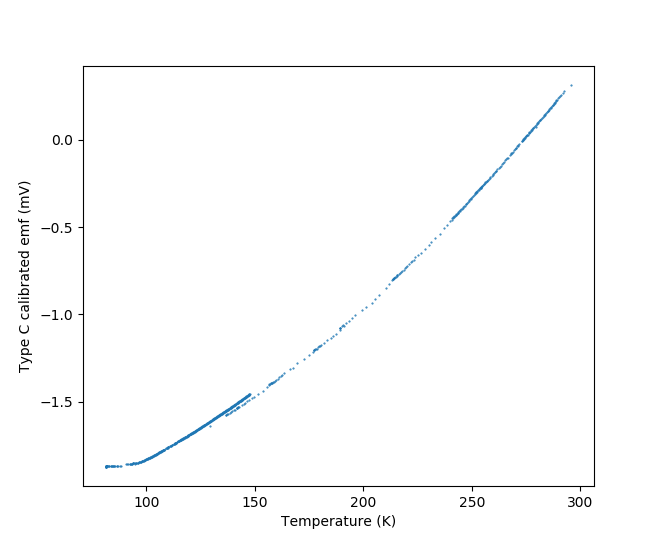

Text(0,0.5,'Type C calibrated emf (mV)')

In [29]:
#  Let's visualize these results
plt.plot(df['T'], df['TypeC_calib_mV'], 'o', ms=0.5 )
plt.xlabel('Temperature (K)')
plt.ylabel('Type C calibrated emf (mV)')

# Interesting. I cooled first to LN2 temperatures and then allowed the sample to heat up slowly by evaporating LN2
# The data agrees fairly well (within ~3 K) between the heating and cooling curves. I didn't heat all the way back up.

In [68]:
# Now lets fit the data to a polynowmial using least squares
fit_coeffs = np.polyfit(df['T'],df['TypeC_calib_mV'], deg = 10 , full=True)
print(fit_coeffs)
fit_poly = np.poly1d(fit_coeffs[0])
print(fit_poly)


(array([-2.46754355e-21,  4.85344379e-18, -4.22385194e-15,  2.13797655e-12,
       -6.95536097e-10,  1.51578678e-07, -2.23445908e-05,  2.19257911e-03,
       -1.36510027e-01,  4.85219279e+00, -7.64825809e+01]), array([0.02046341]), 11, array([3.11815516e+00, 1.07601609e+00, 3.37589714e-01, 7.16742026e-02,
       1.37813883e-02, 1.93756825e-03, 2.47648307e-04, 2.14936570e-05,
       1.52238456e-06, 8.08239508e-08, 2.99280586e-09]), 1.5654144647214707e-13)
            10             9             8             7             6
-2.468e-21 x  + 4.853e-18 x - 4.224e-15 x + 2.138e-12 x - 6.955e-10 x
              5             4            3          2
 + 1.516e-07 x - 2.234e-05 x + 0.002193 x - 0.1365 x + 4.852 x - 76.48


<IPython.core.display.Javascript object>


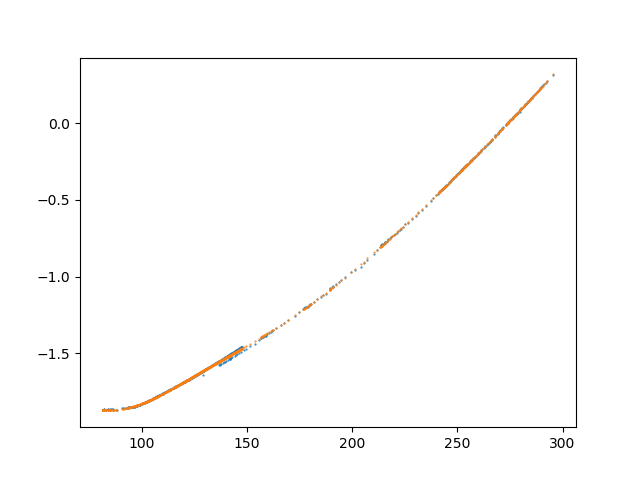

In [69]:
fig, ax = plt.subplots()
ax.plot(df['T'], df['TypeC_calib_mV'],'o',ms='0.5')
ax.plot(df['T'], fit_poly(df['T']) , 'o', ms='0.5')


The 10th degree polynomial appears to give the best fit overall. 
The lower order polynomials dont fit the curve exceedingly well below 100 K

Also, the polynomial tracks the heating curve (the slightly higher mV points from 80-150K) a little more closely than the cooling curve (295 to 80 K). Heating occurred much more slowly than cooling, so I expect it to me more accurate anyways.

In [72]:
# These mV values are also close ~0.5 degrees K of one another
print(fit_poly(273.15))  # fit
print(typeC.emf_mVK(273.15))  # NIST value  

-0.008672368463692237
0.0


Now I will take the polynomial and take the values from 77 K to 273 K for calibration and append them to the NIST values

In [87]:
# low temperature array
low_temp = np.arange(77,273.15, 0.03)
low_temp_calib = fit_poly(low_temp)

# high temperature array
high_temp = np.arange(273.15,2588.15, 0.03)
high_temp_nist = typeC.emf_mVK(high_temp)

# concatentate and put into a dataframe and output to excel
Temperature = np.concatenate([low_temp, high_temp])
TypeC_mV = np.concatenate([low_temp_calib, high_temp_nist])

typeC_calibration = pd.DataFrame(data=TypeC_mV, index=Temperature, dtype='float32', columns = ['Type C (mV)'])
typeC_calibration.index.name = 'Temperature (Kelvin)'

print(typeC_calibration.head())
print(typeC_calibration.tail())

                      Type C (mV)
Temperature (Kelvin)             
77.00                   -1.866275
77.03                   -1.866284
77.06                   -1.866294
77.09                   -1.866303
77.12                   -1.866313
                      Type C (mV)
Temperature (Kelvin)             
2588.01                 37.060013
2588.04                 37.060287
2588.07                 37.060562
2588.10                 37.060837
2588.13                 37.061111


In [88]:
# write to excel
xlwrite = pd.ExcelWriter('Type C calibration.xlsx')
typeC_calibration.to_excel(xlwrite)
xlwrite.save()